In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz
from MyCode import relabeling
from MyCode.relabeling import Leaf

In [2]:
pd.set_option('max_columns', None)
FILE_NAME = "relab_Lawsuit"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

In [3]:
k = 0
depth = 4
random_state = 13
min_supp = 2
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)


In [4]:
clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),8)
discrimation_train_pred = round(relabeling.discrimination(y_train, y_pred_train, sensitive_train), 8)

In [5]:
utils.tree_upgrade2(clf.tree_, y_train, sensitive_train)

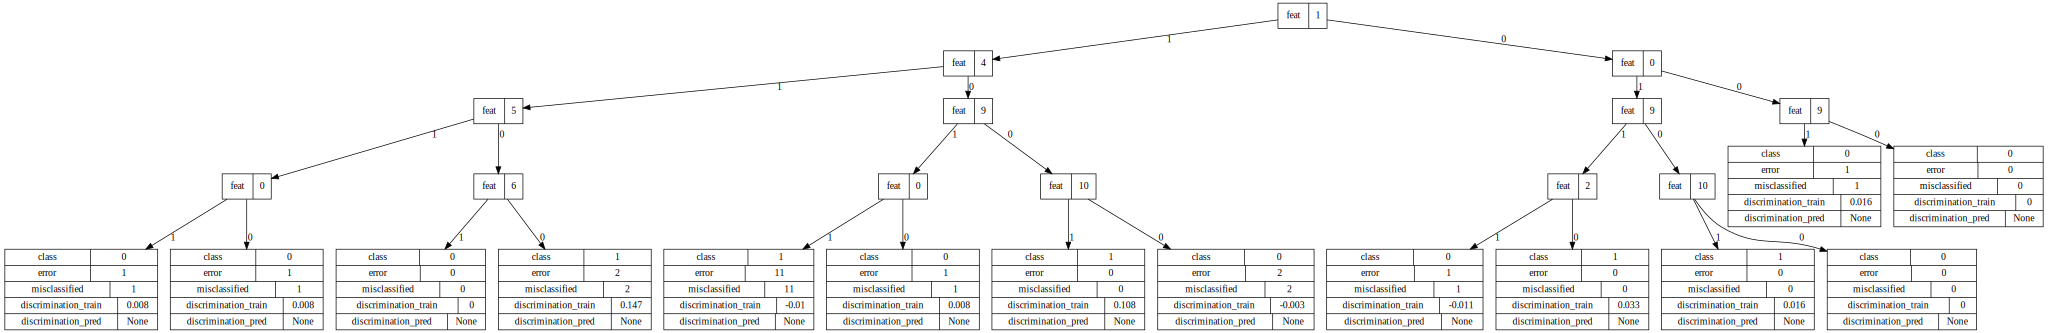

In [6]:
graphviz.Source(utils.export_graphviz(clf))

In [7]:
t = clf.tree_['left']['transactions']
print(utils.discrimination(y_train[t], sensitive_train[t]))
dd = pd.DataFrame(X_train, columns = X.columns)
dd['Sensitive'] = sensitive_train
dd['Class'] = y_train
dd["Pred"] = y_pred_train
print(relabeling.discrimination2(dd))
print(utils.discr_add(t, y_train, sensitive_train))

0.33992467043314506
0.26351987940455995
0.26691162615413605


In [8]:
leafs = list()
cnt = np.unique(sensitive_train, return_counts=True)[1]
leafs_relab = relabeling.relab(clf.tree_, y_train, y_pred_train, sensitive_train, 0)
leafs_relab = relabeling.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, 1)
sum_acc = 0
sum_disc = 0
for leaf in leafs_relab:
    print(leaf)
    print()
    sum_acc += leaf.acc
    sum_disc += leaf.disc
    relabeling.browse_and_relab(clf.tree_, list(leaf.path), leaf)

Path: ((1, 'right'), (0, 'left'), (9, 'left'), (2, 'left')) 
accuracy: -0.014354066985645932 
discrimination: -0.03778029018277747 
ratio: 2.632026882733497 
contigency: 
[0.014354066985645933, 0.004784688995215311]
[0.004784688995215311, 0.0]



In [9]:
y_pred_train = clf.predict(X_train)
accuracy_train_relab = round(accuracy_score(y_train, y_pred_train), 8)
discrimation_train_pred_relab = round(relabeling.discrimination(y_train, y_pred_train, sensitive_train), 8)
new_acc= round(accuracy_train+sum_acc, 8)
new_disc = round(discrimation_train_pred+sum_disc, 8)
sum_acc = round(sum_acc, 8)
sum_disc = round(sum_disc, 8)
print(f"Accuracy:\n"
      f"    Before      : {accuracy_train}\n"
      f"    Leafs       : {sum_acc}\n"
      f"    After       : {accuracy_train_relab}\n"
      f"    Before+Leafs: {new_acc}\n"
      f"    Check       : {new_acc == accuracy_train_relab}\n"
      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
print(f"Discrim:\n"
      f"    Before      : {discrimation_train_pred}\n"
      f"    Leafs       : {sum_disc }\n"
      f"    After       : {discrimation_train_pred_relab}\n"
      f"    Before+Leafs: {new_disc}\n"
      f"    Check       : {new_disc== discrimation_train_pred_relab}\n"
      f"    Real diff   : {discrimation_train_pred - discrimation_train_pred_relab}")
round(relabeling.discrimination(y_train, y_pred_train, sensitive_train), 6) == round(utils.discrimination(y_pred_train, sensitive_train), 6)

Accuracy:
    Before      : 0.89952153
    Leafs       : -0.01435407
    After       : 0.88516746
    Before+Leafs: 0.88516746
    Check       : True
    Real diff   : 0.014354069999999997
Discrim:
    Before      : 0.26351988
    Leafs       : -0.03778029
    After       : 0.22573959
    Before+Leafs: 0.22573959
    Check       : True
    Real diff   : 0.037780289999999994


True

In [10]:
new_disc = round(discrimation_train_pred+sum_disc, 8)

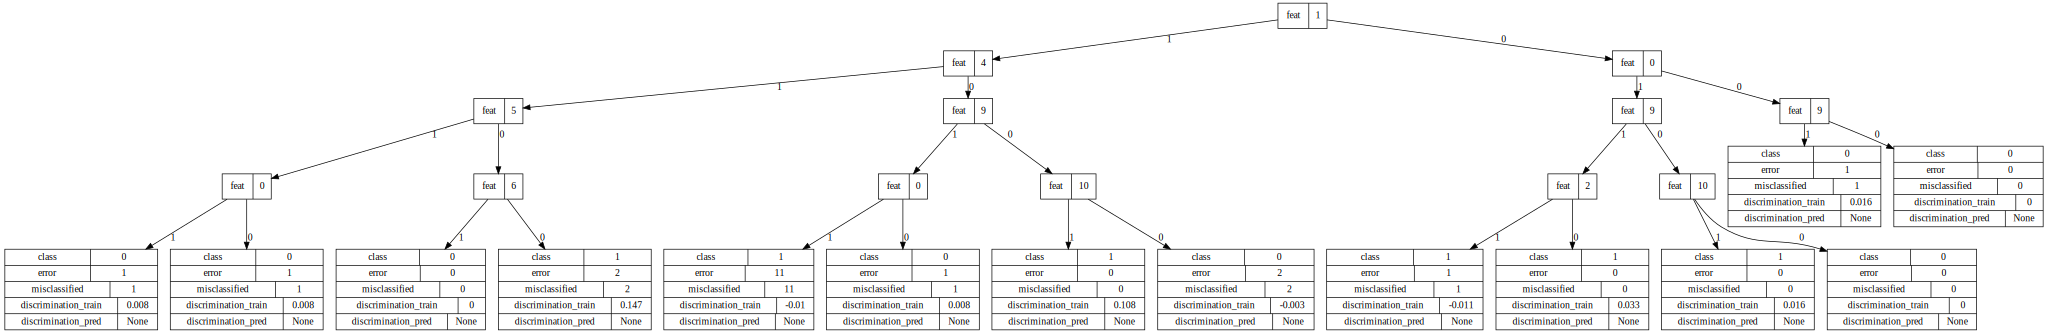

In [11]:
graphviz.Source(utils.export_graphviz(clf))